<a href="https://colab.research.google.com/github/sudarshan-koirala/youtube-stuffs/blob/main/langchain/langchain_qdrant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [Youtube video covering this notebook](https://youtu.be/JSKZYgARffg?si=1i1xr6eSnmAekZ3u)

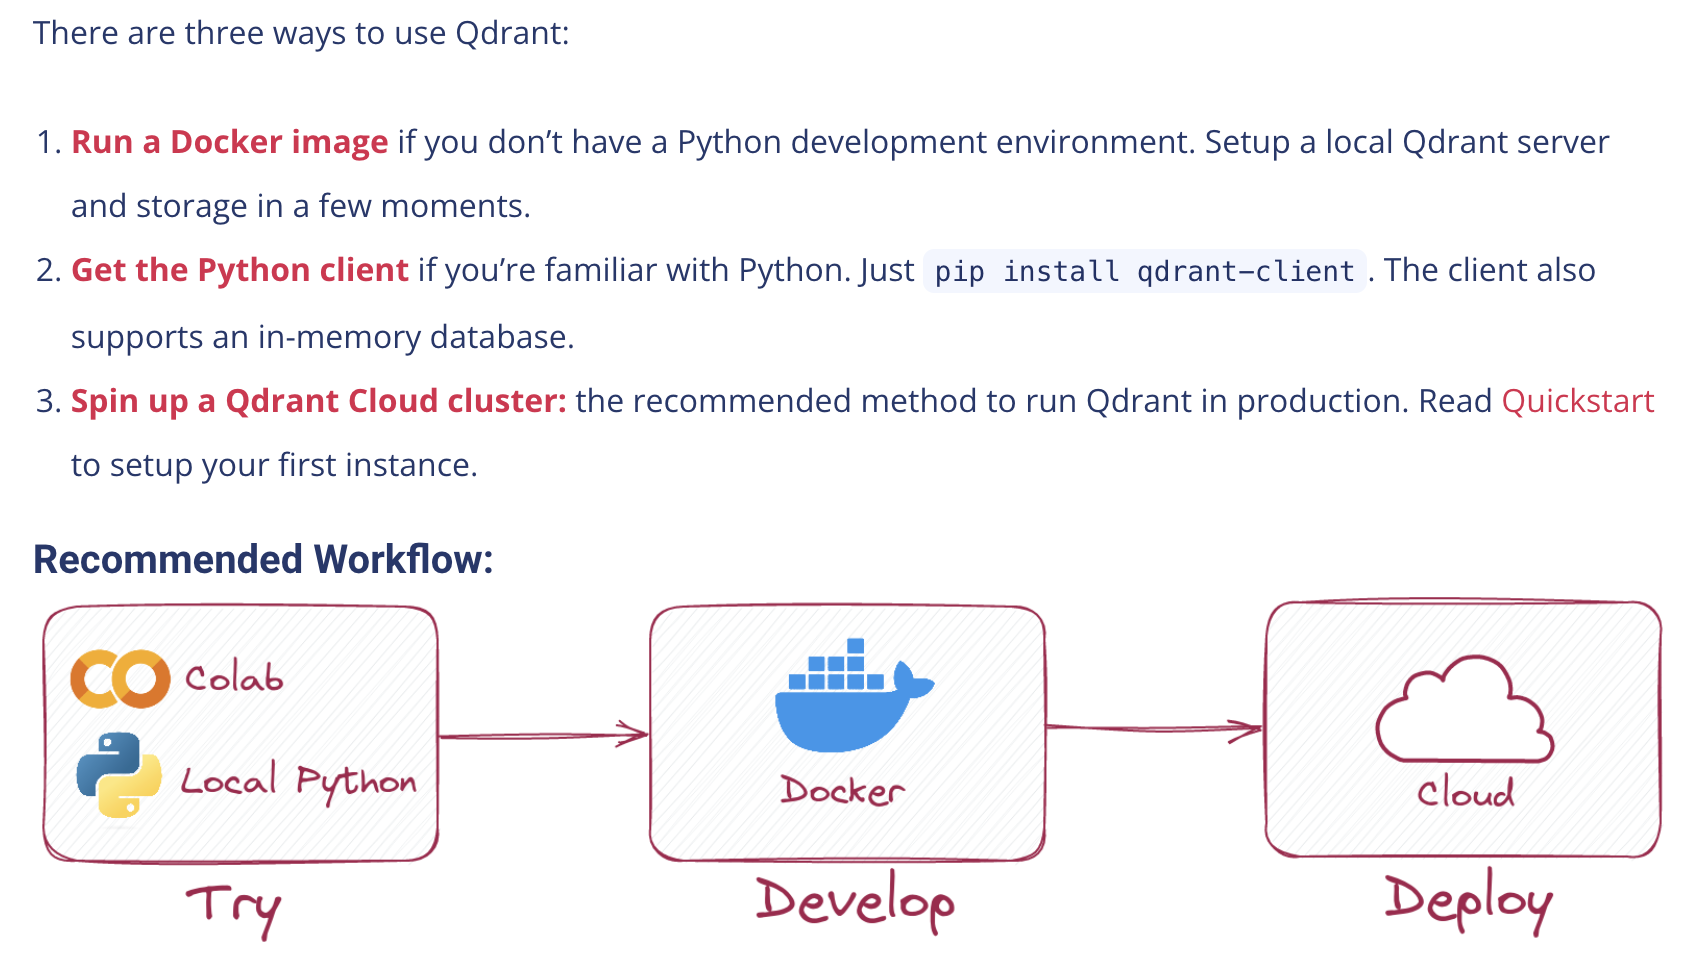

[Qdrant](https://qdrant.tech/documentation/) (read: quadrant ) is a vector similarity search engine.  

There are various modes of how to run Qdrant, and depending on the chosen one, there will be some subtle differences. The options include:   
    - Local mode, no server required  
    - On-premise server deployment --> using docker  
    - [Qdrant Cloud](https://cloud.qdrant.io/login)

In [1]:
%%capture
%pip install --upgrade --quiet  qdrant-client langchain watermark sentence-transformers "unstructured[md]"

In [2]:
%load_ext watermark
%watermark -a "Sudarshan Koirala" -vmp langchain

Author: Sudarshan Koirala

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.22.2

langchain: 0.1.13

Compiler    : Clang 15.0.0 (clang-1500.1.0.2.5)
OS          : Darwin
Release     : 23.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 12
Architecture: 64bit



We want to use HuggingfaceEmbeddings and LLMs from Groq. Get Groq api key from this [link](https://console.groq.com/keys).

In [3]:
import warnings

warnings.filterwarnings("ignore")

In [4]:
from langchain_community.embeddings import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-mpnet-base-v2"
)

In [5]:
embeddings

HuggingFaceEmbeddings(client=SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
), model_name='sentence-transformers/all-mpnet-base-v2', cache_folder=None, model_kwargs={}, encode_kwargs={}, multi_process=False, show_progress=False)

In [6]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.vectorstores import Qdrant
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [7]:
# https://python.langchain.com/docs/modules/data_connection/document_loaders/markdown

loader = DirectoryLoader('data/', glob="**/*.md", show_progress=True)
documents = loader.load()

# Split loaded documents into chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=40)
docs = text_splitter.split_documents(documents)

100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


In [8]:
len(docs)

283

## Connecting to Qdrant from LangChain

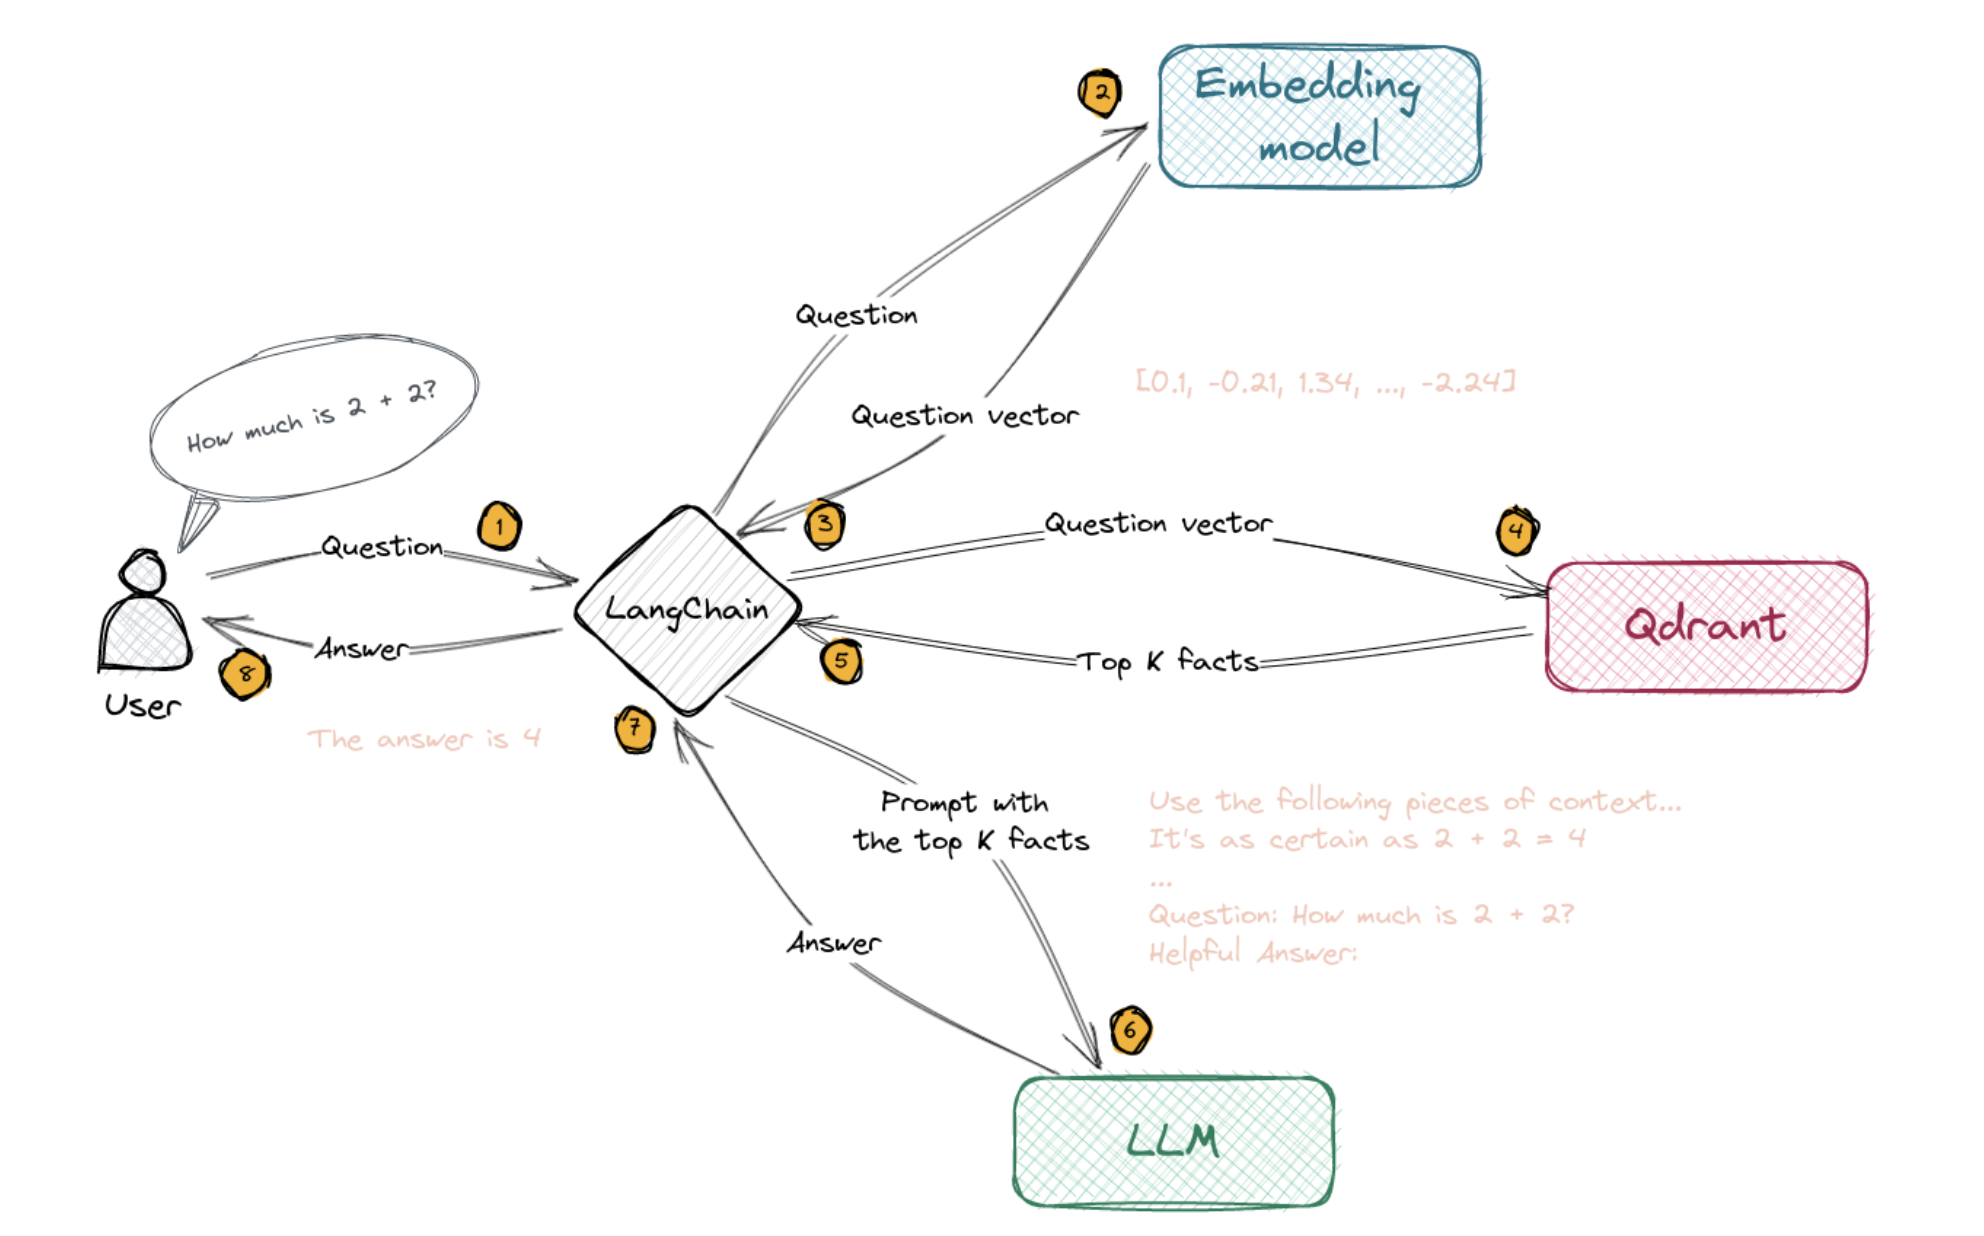

### Local mode

In [10]:
# in-memory
qdrant = Qdrant.from_documents(
    docs,
    embeddings,
    location=":memory:",  # Local mode with in-memory storage only
    collection_name="inmemory_documents",
)

In [11]:
# on-disk storage
qdrant = Qdrant.from_documents(
    docs,
    embeddings,
    path="./",
    collection_name="ondisk_documents",
)

### Similarity search

In [12]:
query = "what is the net loss value attributable to Uber compared to last year?"

In [13]:
found_docs = qdrant.similarity_search(query)
print(found_docs[0].page_content)

Net Loss Including Non-Controlling Interests
($122)
($5,918)

Net Loss Attributable to Uber Technologies, Inc.
($108)
($5,930)

Net Loss Per Share Attributable to Uber Technologies, Inc. Common Stockholders

Basic
($0.06)
($3.03)

Diluted
($0.06)
($3.04)

Weighted-Average Shares Used to Compute Net Loss Per Share Attributable to Common Stockholders

Basic
1,858,525
1,953,989

Diluted
1,858,525
1,957,731

The accompanying notes are an integral part of these condensed consolidated financial statements.

Uber Quarterly Report

Uber Technologies, Inc. - Condensed Consolidated Statements of Comprehensive Income (Loss)

Three Months Ended March 31, 2021
Three Months Ended March 31, 2022

Net loss including non-controlling interests
($122 million)
($5,918 million)

Other comprehensive income, net of tax:

Change in foreign currency translation adjustment
$33 million
$19 million

Change in unrealized gain on investments in available-for-sale securities
$1,156 million
$—


In [14]:
len(found_docs)

4

### Similarity search with scores

In [18]:
found_docs = qdrant.similarity_search_with_score(query)

document, score = found_docs[3]
print(document.page_content)
print(f"\nScore: {score}")

Three Months Ended March 31, 2021
Three Months Ended March 31, 2022

Revenue
100%
100%

Costs and expenses

Cost of revenue, exclusive of depreciation and amortization
59%
59%

Operations and support
15%
8%

Sales and marketing
38%
18%

Research and development
18%
9%

General and administrative
16%
9%

Depreciation and amortization
7%
4%

Total costs and expenses
152%
107%

Loss from operations
(52%)
(7%)

Interest expense
(4%)
(2%)

Other income (expense), net
59%
(81%)

Income (loss) before income taxes and income (loss) from equity method investments
2%
(90%)

Provision for (benefit from) income taxes
6%
(3%)

Income (loss) from equity method investments
—
—

Net loss including non-controlling interests
(4%)
(86%)

Less: net income (loss) attributable to non-controlling interests, net of tax
—
—

Net loss attributable to Uber Technologies, Inc.
(4%)
(87%)

(1) Totals of percentage of revenues may not foot due to rounding.

Uber Technologies, Inc. Quarterly Report

Score: 0.75642597

## On-premise server deployment
- https://qdrant.tech/
- Make sure you have [docker](https://www.docker.com/) installed

In [19]:
url_localhost = "http://localhost:6333"
qdrant_docker = Qdrant.from_documents(
    docs,
    embeddings,
    url=url_localhost,
    prefer_grpc=False,
    collection_name="server_documents",
)

In [20]:
found_docs_docker = qdrant_docker.similarity_search(query)
print(found_docs_docker[0].page_content)

Net Loss Including Non-Controlling Interests
($122)
($5,918)

Net Loss Attributable to Uber Technologies, Inc.
($108)
($5,930)

Net Loss Per Share Attributable to Uber Technologies, Inc. Common Stockholders

Basic
($0.06)
($3.03)

Diluted
($0.06)
($3.04)

Weighted-Average Shares Used to Compute Net Loss Per Share Attributable to Common Stockholders

Basic
1,858,525
1,953,989

Diluted
1,858,525
1,957,731

The accompanying notes are an integral part of these condensed consolidated financial statements.

Uber Quarterly Report

Uber Technologies, Inc. - Condensed Consolidated Statements of Comprehensive Income (Loss)

Three Months Ended March 31, 2021
Three Months Ended March 31, 2022

Net loss including non-controlling interests
($122 million)
($5,918 million)

Other comprehensive income, net of tax:

Change in foreign currency translation adjustment
$33 million
$19 million

Change in unrealized gain on investments in available-for-sale securities
$1,156 million
$—


## Qdrant Cloud
If you prefer not to keep yourself busy with managing the infrastructure, you can choose to set up a fully-managed Qdrant cluster on [Qdrant Cloud](https://cloud.qdrant.io/). There is a free forever 1GB cluster included for trying out. The main difference with using a managed version of Qdrant is that you’ll need to provide an API key to secure your deployment from being accessed publicly.

In [33]:
qdrant_cloud_api_key="your_qdrant_cloud_api_key"
qdrant_url="your_qdrant_url"

In [22]:
qdrant_cloud = Qdrant.from_documents(
    docs,
    embeddings,
    url=qdrant_url,
    prefer_grpc=True,
    api_key=qdrant_cloud_api_key,
    collection_name="qdrant_cloud_documents",
)

In [23]:
found_docs_cloud = qdrant_cloud.similarity_search(query)
print(len(found_docs_cloud))
print(found_docs_cloud[0].page_content)

4
Net Loss Including Non-Controlling Interests
($122)
($5,918)

Net Loss Attributable to Uber Technologies, Inc.
($108)
($5,930)

Net Loss Per Share Attributable to Uber Technologies, Inc. Common Stockholders

Basic
($0.06)
($3.03)

Diluted
($0.06)
($3.04)

Weighted-Average Shares Used to Compute Net Loss Per Share Attributable to Common Stockholders

Basic
1,858,525
1,953,989

Diluted
1,858,525
1,957,731

The accompanying notes are an integral part of these condensed consolidated financial statements.

Uber Quarterly Report

Uber Technologies, Inc. - Condensed Consolidated Statements of Comprehensive Income (Loss)

Three Months Ended March 31, 2021
Three Months Ended March 31, 2022

Net loss including non-controlling interests
($122 million)
($5,918 million)

Other comprehensive income, net of tax:

Change in foreign currency translation adjustment
$33 million
$19 million

Change in unrealized gain on investments in available-for-sale securities
$1,156 million
$—


- the collection is going to be reused if it already exists. 
- Setting `force_recreate` to `True` allows to remove the old collection and start from scratch.

In [24]:
qdrant_cloud = Qdrant.from_documents(
    docs,
    embeddings,
    url=qdrant_url,
    prefer_grpc=True,
    api_key=qdrant_cloud_api_key,
    collection_name="qdrant_cloud_documents",
    force_recreate=True
)

## Groq, Langchain Expression Language (LCEL), Qdrant
- LangChain Expression Language, or LCEL, is a declarative way to easily compose chains together.

In [25]:
%%capture
%pip install langchain-groq

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
# import getpass
# import os

# os.environ["GROQ_API_KEY"] = getpass.getpass("GROQ API Key:")
# GROQ_API_KEY = os.getenv("GROQ_API_KEY")

In [34]:
GROQ_API_KEY = "YOUR_GROQ_API_KEY"

In [27]:
from langchain_groq import ChatGroq
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough

In [30]:
retriever = qdrant_cloud.as_retriever()
#retreiver = qdrant_docker.as_retriever()
#retreiver = qdrant.as_retriever()

template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

chat_model = ChatGroq(temperature=0, api_key= GROQ_API_KEY, model_name="mixtral-8x7b-32768")

In [31]:
chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | chat_model
    | StrOutputParser()
)

In [32]:
from IPython.display import Markdown, display
response = chain.invoke(query)
display(Markdown(f"<b>{response}</b>"))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


<b>The net loss attributable to Uber Technologies, Inc. for the three months ended March 31, 2022 is $(5,930) million, compared to a net loss of $(108) million for the same period last year. Therefore, the net loss attributable to Uber has increased by $(5,822) million compared to the same period last year.</b>